In [9]:
!ls

Untitled.ipynb	google-drive-ocamlfuse	my_drive


In [16]:
import gdown

# a file
url = "https://drive.google.com/drive/folders/19Eb_WiTsWelYv7Faff0L5Lmo1zv0vzwR?usp=drive_link"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/home/jupyter/data/image/origin.7z.001',
 '/home/jupyter/data/image/origin.7z.002',
 '/home/jupyter/data/image/origin.7z.003',
 '/home/jupyter/data/image/origin.7z.004',
 '/home/jupyter/data/image/origin.7z.005',
 '/home/jupyter/data/image/origin.7z.006',
 '/home/jupyter/data/image/origin.7z.007',
 '/home/jupyter/data/image/origin.7z.008',
 '/home/jupyter/data/label/label.lst',
 '/home/jupyter/data/label/readme.txt']

In [4]:
import subprocess

# Replace 'path_to_your_archive.7z' with the actual path to your 7z file
archive_path = "data/image/origin.7z.*"
destination_path = "my_drive/processed_data/origin"  # Destination path for extraction

# Run the 7za command to extract the archive
process = subprocess.Popen(['7za', '-y', 'e', archive_path, f'-o{destination_path}'], stderr=subprocess.PIPE)

# Continuously read and print the progress updates
while True:
    line = process.stderr.readline()
    if not line:
        break
    print(line.decode().strip())

# Wait for the process to finish
process.wait()

# Check the return code to see if the extraction was successful
if process.returncode == 0:
    print("Extraction successful.")
else:
    print(f"Extraction failed with return code {process.returncode}.")



7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
8 files, 8113576419 bytes (7738 MiB)

Extracting archive: data/image/origin.7z.001
--
Path = data/image/origin.7z.001
Type = Split
Physical Size = 1048576000
Volumes = 8
Total Physical Size = 8113576419
----
Path = origin.7z
Size = 8113576419
--
Path = origin.7z
Type = 7z
Physical Size = 8113576419
Headers Size = 863607
Method = LZMA:25
Solid = +
Blocks = 2

Everything is Ok

Folders: 1
Files: 106962
Size:       8386671768
Compressed: 8113576419
Extraction successful.


In [1]:
import numpy as np
import os
import glob
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

2023-07-21 16:25:50.136504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_dir = "my_drive/processed_data/origin/"

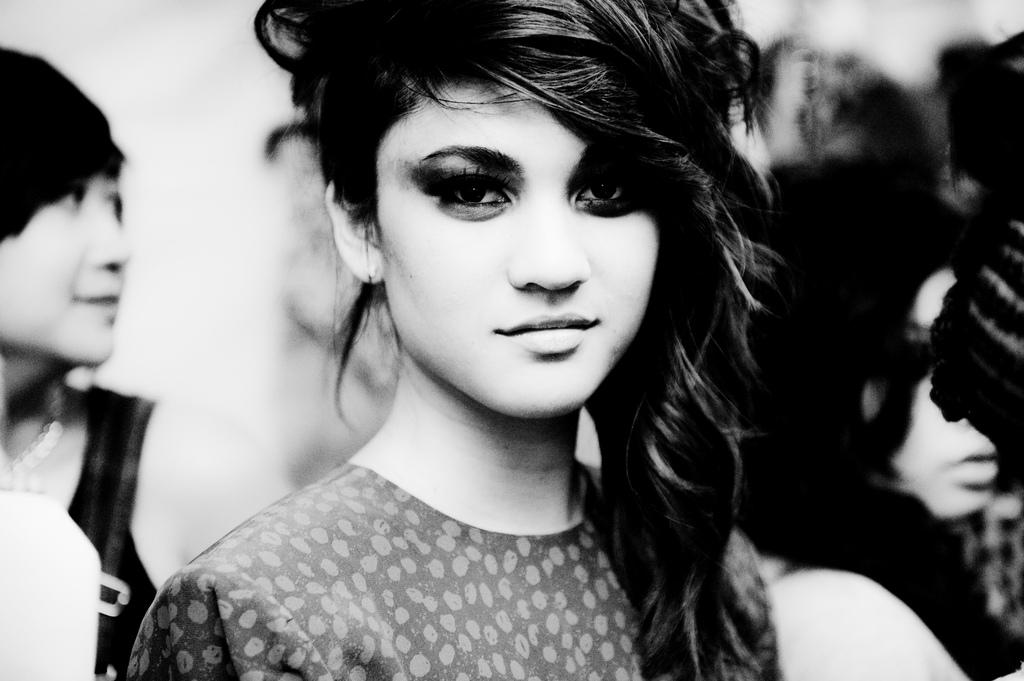

In [3]:
images = list(glob.glob(os.path.join(image_dir, '*.jpg')))
PIL.Image.open(str(images[5]))

In [4]:
image_count = len(list(glob.glob(os.path.join(image_dir, '*.jpg'))))
print("Total images: ", image_count)

Total images:  106962


In [5]:
labels_file = "data/label/label.lst"
df = pd.read_csv(labels_file, header=None, delimiter = " ", names=["image_name", "face_id_in_image", "face_box_top", "face_box_left", "face_box_right", "face_box_bottom", "face_box_cofidence", "expression_label"])


In [6]:
df.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [11]:
labels_name = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

In [12]:
file_paths = df['image_name']
labels = df['expression_label']
list_ds = tf.data.Dataset.list_files(os.path.join("my_drive/processed_data/", '*/*'), shuffle=False)

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
new_data_path='my_drive/classes/'
for lbl in labels_name:
    os.makedirs(os.path.join(new_data_path,lbl),exist_ok=True)

In [15]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Create a mapper dictionary that maps labels to folder names
mapper = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

origin_folder_path = "my_drive/processed_data/origin"
final_data_path = "my_drive/classes/"

for label in tqdm(df.expression_label.unique()):
    new_df = df[df.expression_label == label]
    folder_name = mapper[label]

    # Skip processing when label is '.ipynb_checkpoints'
    if folder_name == '.ipynb_checkpoints':
        continue

    for image_name in new_df.image_name:
        img = cv2.imread(os.path.join(origin_folder_path, image_name))
        if img is not None:
            full_path = os.path.join(final_data_path, folder_name)
            os.makedirs(full_path, exist_ok=True)  # Create the subdirectory if it doesn't exist
            full_path_with_name = os.path.join(full_path, os.path.basename(image_name))
            cv2.imwrite(full_path_with_name, img)


100%|██████████| 7/7 [34:51<00:00, 298.85s/it]


In [16]:
!rm -rf my_drive/classes/.ipynb_checkpoints

In [17]:
 
train_ds = tf.keras.utils.image_dataset_from_directory(
  final_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 74532 files belonging to 7 classes.
Using 59626 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  final_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 74532 files belonging to 7 classes.
Using 14906 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [39]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [43]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [45]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

2023-07-21 15:56:20.078561: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129777664 exceeds 10% of free system memory.
2023-07-21 15:56:20.210399: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32444416 exceeds 10% of free system memory.
2023-07-21 15:56:20.305419: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 6 which is outside the valid range of [0, 5).  Label values: 4 3 3 3 5 4 3 3 3 5 5 4 4 6 1 4 3 5 2 3 1 4 2 4 4 4 5 3 0 0 6 4


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/tmp/ipykernel_46797/2386738274.py", line 1, in <module>
      model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 6 which is outside the valid range of [0, 5).  Label values: 4 3 3 3 5 4 3 3 3 5 5 4 4 6 1 4 3 5 2 3 1 4 2 4 4 4 5 3 0 0 6 4
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_2086]